CODE POUR CONVERTIR JSON EN MASKS

In [1]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os


In [27]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os

# Charger le fichier JSON
json_path = "./labels_x.json"
with open(json_path, 'r') as f:
    data = json.load(f)

# Chemin pour enregistrer les masques générés
output_dir = "./MASKS_TEST_X"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dimensions des images (par défaut, remplacez si nécessaire)
width = 1250  # Remplacez par la largeur réelle de vos images
height = 1250  # Remplacez par la hauteur réelle de vos images

# Génération des masques pour chaque image
for image_filename, image_data in data.items():
    mask = Image.new("L", (width, height), 0)  # Créer un masque noir
    draw = ImageDraw.Draw(mask)

    print(f"Traitement de l'image : {image_filename}")

    for region in image_data['regions'].values():
        points_x = region['shape_attributes']['all_points_x']
        points_y = region['shape_attributes']['all_points_y']
        polygon = [(x, y) for x, y in zip(points_x, points_y)]

        # Debugging : Afficher les coordonnées du polygone
        print(f"Polygone : {polygon}")

        # Dessiner le polygone sur le masque
        draw.polygon(polygon, outline=255, fill=255)

    # Sauvegarder le masque
    mask_filename = os.path.splitext(image_filename)[0] + "_mask.png"
    mask.save(os.path.join(output_dir, mask_filename))

print(f"Masques générés et sauvegardés dans {output_dir}")


Traitement de l'image : 0001.png
Polygone : [(416.6666666666667, 281.0846560846561), (429.8941798941799, 257.93650793650795), (449.7354497354497, 239.74867724867727), (477.84391534391534, 221.56084656084656), (500.9920634920635, 221.56084656084656), (539.021164021164, 213.2936507936508), (573.7433862433862, 213.2936507936508), (615.0793650793651, 200.06613756613757), (654.7619047619048, 198.41269841269843), (671.2962962962963, 205.02645502645504), (702.7116402116402, 196.75925925925927), (737.4338624338625, 195.1058201058201), (768.8492063492064, 203.37301587301587), (778.7698412698413, 223.21428571428572), (806.878306878307, 214.94708994708995), (836.6402116402116, 213.2936507936508), (859.7883597883598, 216.60052910052912), (887.8968253968254, 218.25396825396825), (897.8174603174604, 228.1746031746032), (914.3518518518518, 216.60052910052912), (930.8862433862435, 226.52116402116403), (947.4206349206349, 241.4021164021164), (962.3015873015873, 233.13492063492063), (985.4497354497355, 

TEST RESEAU DE NEURONNES AVEC IMAGES SIMPLES

In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model

# Chemins vers vos images et masques
image_path = './imgtest/'
mask_path = './MASKS_CARRE/'

# Paramètres de l'image
img_height, img_width = 512, 512

def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    for filename in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, filename), target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0  # Normalisation de l'image
        images.append(img)
        
        mask_filename = os.path.splitext(filename)[0] + "_mask.png"
        mask = load_img(os.path.join(mask_dir, mask_filename), color_mode="grayscale", target_size=(img_height, img_width))
        mask = img_to_array(mask) / 255.0  # Normalisation du masque pour être entre 0 et 1
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Charger les images et les masques
images, masks = load_images_and_masks(image_path, mask_path)

# Fonction pour construire le modèle U-Net
def unet_model(input_size=(img_height, img_width, 3)):
    inputs = Input(input_size)
    
    # Encodeur
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Décodeur
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Créer le modèle
model = unet_model()

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit(images, masks, batch_size=8, epochs=50, validation_split=0.1)

# Sauvegarder le modèle
model.save('unet_model.h5')


Epoch 1/50


In [4]:
from keras.models import load_model

# Charger le modèle U-Net sauvegardé
model = load_model('unet_model.h5')


In [2]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Chemin vers l'image de test
test_image_path = './imgvalidation/11.png'

# Charger et prétraiter l'image de test
test_img = load_img(test_image_path, target_size=(img_height, img_width))
test_img = img_to_array(test_img) / 255.0  # Normalisation
test_img = np.expand_dims(test_img, axis=0)  # Ajouter une dimension pour le batch


In [5]:
# Prédire le masque pour l'image de test
predicted_mask = model.predict(test_img)

# Convertir la prédiction en masque binaire (0 ou 1)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Si vous voulez visualiser le masque, il faut enlever la dimension du batch
predicted_mask = np.squeeze(predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


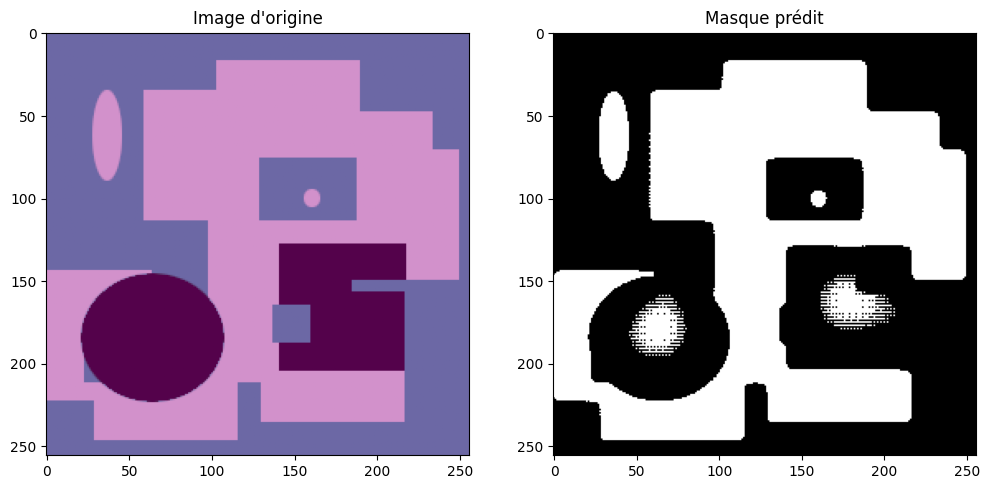

In [6]:
# Afficher l'image d'origine et le masque prédit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img))  # Afficher l'image originale
plt.title("Image d'origine")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')  # Afficher le masque prédit
plt.title("Masque prédit")

plt.show()


In [ ]:
from PIL import Image

# Convertir le masque prédit en image PIL
predicted_mask_img = Image.fromarray((predicted_mask * 255).astype(np.uint8))

# Sauvegarder l'image du masque prédit
predicted_mask_img.save('chemin/vers/le/fichier_de_sortie.png')


RESEAU NEURONNE FINAL

In [41]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras import backend as K

# Chemins vers vos images et masques
image_path = './UNET/IMG_SOURCE/IMG_CV'
mask_path = './UNET/MASKS/MSK_CV'

# Paramètres de l'image
img_height, img_width = 256, 256

# Fonction pour charger les images et masques
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    for filename in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, filename), target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0  # Normalisation des images
        images.append(img)
        
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask = load_img(os.path.join(mask_dir, mask_filename), color_mode="grayscale", target_size=(img_height, img_width))
        mask = img_to_array(mask) / 255.0  # Normalisation des masques
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Charger les images et les masques
images, masks = load_images_and_masks(image_path, mask_path)

# Fonction pour construire le modèle U-Net
def unet_model(input_size=(img_height, img_width, 3)):
    inputs = Input(input_size)
    
    # Encodeur
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Décodeur
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Créer le modèle
model = unet_model()

# ---- Partie ajoutée pour la fonction dice_loss ----
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)  # Utilise tf.keras.backend.flatten
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


# Compiler le modèle avec la Dice Loss et Binary Cross-Entropy combinée
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_loss, 'accuracy'])
# --------------------------------------------------

# Entraîner le modèle
model.fit(images, masks, batch_size=16, epochs=40, validation_split=0.2)

# Sauvegarder le modèle
model.save('testGLUT.h5')


Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3899s 26s/step - accuracy: 0.8985 - dice_loss: 0.8767 - loss: 0.2815 - val_accuracy: 0.9512 - val_dice_loss: 0.5146 - val_loss: 0.0945
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3890s 26s/step - accuracy: 0.9518 - dice_loss: 0.4849 - loss: 0.0957 - val_accuracy: 0.9512 - val_dice_loss: 0.5293 - val_loss: 0.0921
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3885s 26s/step - accuracy: 0.9668 - dice_loss: 0.3051 - loss: 0.0620 - val_accuracy: 0.9653 - val_dice_loss: 0.4033 - val_loss: 0.0686
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3874s 26s/step - accuracy: 0.9613 - dice_loss: 0.3662 - loss: 0.0757 - val_accuracy: 0.9749 - val_dice_loss: 0.2046 - val_loss: 0.0387
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3873s 26s/step - accuracy: 0.9752 - dice_loss: 0.1817 - loss: 0.0371 - val_accuracy: 0.9769 - val_dice_loss: 0.1385 - val_loss: 0.0309
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 3874s 26s/step - accuracy: 0.9782 - dice_loss: 0.1323 - loss: 0.0280 - val_accuracy: 

In [42]:
from keras.models import load_model

# Charger le modèle U-Net sauvegardé
model = load_model('testGLUT.h5')


In [43]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Chemin vers l'image de test
test_image_path = './UNET/IMG_SOURCE/IMG_C/0020.png'

# Charger et prétraiter l'image de test
test_img = load_img(test_image_path, target_size=(img_height, img_width))
test_img = img_to_array(test_img) / 255.0  # Normalisation
test_img = np.expand_dims(test_img, axis=0)  # Ajouter une dimension pour le batch


In [44]:
# Prédire le masque pour l'image de test
predicted_mask = model.predict(test_img)

# Convertir la prédiction en masque binaire (0 ou 1)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Si vous voulez visualiser le masque, il faut enlever la dimension du batch
predicted_mask = np.squeeze(predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


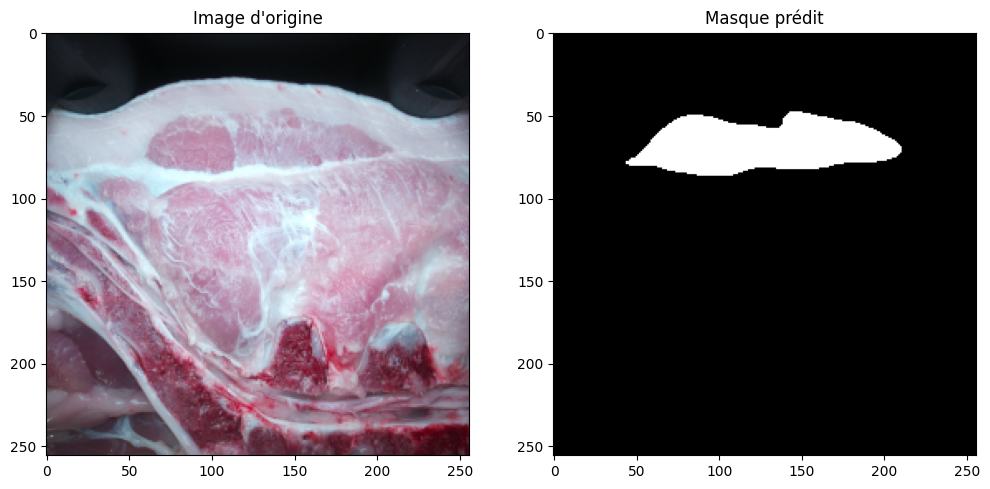

In [45]:
# Afficher l'image d'origine et le masque prédit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img))  # Afficher l'image originale
plt.title("Image d'origine")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')  # Afficher le masque prédit
plt.title("Masque prédit")

plt.show()


CODE SUPERPOSITION

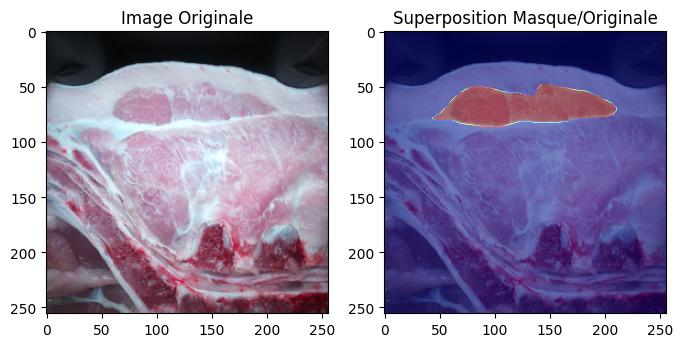

In [46]:
# Affichage avec superposition
plt.figure(figsize=(8, 8))

# Afficher l'image originale
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_img))
plt.title('Image Originale')

# Superposer le masque sur l'image originale
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(test_img))  # Image originale en fond
plt.imshow(predicted_mask, cmap='jet', alpha=0.5)  # Masque en semi-transparence (alpha=0.5)
plt.title('Superposition Masque/Originale')

plt.show()


TEST DOSSIER COMPLET

In [48]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Dossier contenant les images de test
test_image_dir = './UNET/IMG_SOURCE/IMG_V/'

# Dossier où les résultats seront sauvegardés
output_dir = './UNET/IMG_SOURCE/RESULTS_VV2/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Liste des fichiers d'images dans le dossier
test_image_files = [f for f in os.listdir(test_image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Parcourir chaque fichier image dans le dossier
for image_file in test_image_files:
    # Chemin complet de l'image
    image_path = os.path.join(test_image_dir, image_file)
    
    # Charger et prétraiter l'image de test
    test_img = load_img(image_path, target_size=(img_height, img_width))
    test_img_array = img_to_array(test_img) / 255.0  # Normalisation
    test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch
    
    # Prédire le masque pour l'image de test
    predicted_mask = model.predict(test_img_array)
    
    # Convertir la prédiction en masque binaire (0 ou 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    
    # Supprimer la dimension du batch
    predicted_mask = np.squeeze(predicted_mask)
    
    # Créer une figure pour l'affichage
    plt.figure(figsize=(8, 8))
    
    # Afficher l'image originale
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(test_img_array))
    plt.title(f'Image Originale: {image_file}')
    
    # Superposer le masque sur l'image originale
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(test_img_array))  # Image originale en fond
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)  # Masque en semi-transparence
    plt.title(f'Superposition Masque: {image_file}')
    
    # Sauvegarder la figure dans le dossier de résultats
    output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_overlay.png')
    plt.savefig(output_path)  # Sauvegarder la figure dans le fichier
    
    # Fermer la figure pour libérer la mémoire
    plt.close()

print(f"Résultats sauvegardés dans {output_dir}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

RENOMMER FICHIERS

In [39]:
import os

def renommer_fichiers(dossier, nom_base, extension):
    # Extraire le numéro initial du nom de base
    numero_initial = int(''.join(filter(str.isdigit, nom_base)))
    
    # Récupérer la liste des fichiers dans le dossier
    fichiers = os.listdir(dossier)
    
    # Trier les fichiers par ordre alphabétique
    fichiers.sort()

    # Renommer chaque fichier en suivant le format du nom de base
    for i, fichier in enumerate(fichiers):
        # Extraire l'extension du fichier
        nom_fichier, ext = os.path.splitext(fichier)
        
        # Renommer uniquement si l'extension correspond
        if ext == extension:
            nouveau_nom = f"{str(numero_initial + i).zfill(4)}{extension}"
            ancien_chemin = os.path.join(dossier, fichier)
            nouveau_chemin = os.path.join(dossier, nouveau_nom)
            
            os.rename(ancien_chemin, nouveau_chemin)
            print(f"Renommé: {ancien_chemin} -> {nouveau_chemin}")

# Exemple d'utilisation
dossier = "./UNET/MASKS/MSK_CV"  # Remplace par le chemin du dossier
nom_base = "0001.png"  # Nom de base à partir duquel incrémenter
extension = ".png"  # Extension des fichiers à renommer

renommer_fichiers(dossier, nom_base, extension)


Renommé: ./UNET/MASKS/MSK_CV\aug_mask_0_188.png -> ./UNET/MASKS/MSK_CV\0001.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_0_9200.png -> ./UNET/MASKS/MSK_CV\0002.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1000_8206.png -> ./UNET/MASKS/MSK_CV\0003.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1000_9487.png -> ./UNET/MASKS/MSK_CV\0004.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1001_1262.png -> ./UNET/MASKS/MSK_CV\0005.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1001_7402.png -> ./UNET/MASKS/MSK_CV\0006.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1001_8426.png -> ./UNET/MASKS/MSK_CV\0007.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1002_157.png -> ./UNET/MASKS/MSK_CV\0008.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1002_2335.png -> ./UNET/MASKS/MSK_CV\0009.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1002_5025.png -> ./UNET/MASKS/MSK_CV\0010.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1003_3053.png -> ./UNET/MASKS/MSK_CV\0011.png
Renommé: ./UNET/MASKS/MSK_CV\aug_mask_1003_4469.png -> ./UNET/MASKS/MSK_CV\0012.png


AUGMENTATION DES DONNEES

In [35]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img

# Chemins vers vos images et masques
image_path = './UNET/IMG_SOURCE/IMG_CV'
mask_path = './UNET/MASKS/MSK_CV'

# Chemins pour sauvegarder les images et masques augmentés
aug_image_path = './UNET/IMG_SOURCE/AUG_IMG_CV2'
aug_mask_path = './UNET/MASKS/AUG_MSK_CV2'

# Paramètres de l'image
img_height, img_width = 256, 256

# Créer une instance d'augmentation de données
data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Générateur d'images et de masques
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fonction pour charger les images et masques
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    for filename in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, filename), target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0  # Normalisation des images
        images.append(img)
        
        mask_filename = os.path.splitext(filename)[0] + ".png"
        mask = load_img(os.path.join(mask_dir, mask_filename), color_mode="grayscale", target_size=(img_height, img_width))
        mask = img_to_array(mask) / 255.0  # Normalisation des masques
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Charger les images et masques
images, masks = load_images_and_masks(image_path, mask_path)

# Vérifier que les dossiers de sortie existent, sinon les créer
os.makedirs(aug_image_path, exist_ok=True)
os.makedirs(aug_mask_path, exist_ok=True)

# Préparer les générateurs synchronisés
seed = 1  # Utiliser le même seed pour les deux générateurs
batch_size = 1  # Peut être ajusté

image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed, save_to_dir=aug_image_path, save_prefix='aug_img', save_format='png')
mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed, save_to_dir=aug_mask_path, save_prefix='aug_mask', save_format='png')

# Générateur combiné pour synchroniser les images et les masques
train_generator = zip(image_generator, mask_generator)

# Nombre d'images à générer
num_augmented_images = 3000  # Ajustez ce nombre pour créer plus ou moins d'augmentations

# Générer et sauvegarder les images augmentées
for i in range(num_augmented_images):
    img, mask = next(train_generator)  # Obtenir la prochaine paire image/masque augmentée
    print(f'Image et masque augmentés {i+1}/{num_augmented_images} générés.')


Image et masque augmentés 1/3000 générés.
Image et masque augmentés 2/3000 générés.
Image et masque augmentés 3/3000 générés.
Image et masque augmentés 4/3000 générés.
Image et masque augmentés 5/3000 générés.
Image et masque augmentés 6/3000 générés.
Image et masque augmentés 7/3000 générés.
Image et masque augmentés 8/3000 générés.
Image et masque augmentés 9/3000 générés.
Image et masque augmentés 10/3000 générés.
Image et masque augmentés 11/3000 générés.
Image et masque augmentés 12/3000 générés.
Image et masque augmentés 13/3000 générés.
Image et masque augmentés 14/3000 générés.
Image et masque augmentés 15/3000 générés.
Image et masque augmentés 16/3000 générés.
Image et masque augmentés 17/3000 générés.
Image et masque augmentés 18/3000 générés.
Image et masque augmentés 19/3000 générés.
Image et masque augmentés 20/3000 générés.
Image et masque augmentés 21/3000 générés.
Image et masque augmentés 22/3000 générés.
Image et masque augmentés 23/3000 générés.
Image et masque augm